This notebook reads OSM into NetworkX.

In [1]:
from dataclasses import dataclass
import os
from pathlib import Path

from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import networkx as nx

In [2]:
dataroot = Path(os.getcwd()).parent / 'data'
print(dataroot)

C:\Users\matthew\repos\quoth-unquoth-data\data


In [3]:
with open(dataroot / 'cbr-highways.osm', 'r', encoding='utf-8') as f:
    soup = BeautifulSoup(f.read(), 'xml')

Build a graph and add all the nodes to it.

In [4]:
G = nx.Graph()

In [5]:
@dataclass
class Node:
    id: int
    lat: float
    lon: float
        
    def __hash__(self):
        return hash((self.id, self.lat, self.lon))

In [6]:
nodes = soup('node')

In [7]:
nodes_by_id = {}

In [8]:
for node in nodes:
    node = Node(id=int(node['id']), lat=float(node['lat']), lon=float(node['lon']))
    nodes_by_id[node.id] = node
    G.add_node(node)

Then add links. These are stored as "ways".

In [9]:
ways = soup('way')

In [10]:
highways = set()
for way in ways:
    for tag in way('tag'):
        if tag['k'] == 'highway':
            highways.add(tag['v'])

There are a few different kinds of way. Let's only read in some: motorway, primary, secondary, residential, tertiary, and *_link.

In [11]:
highways

{'bridleway',
 'construction',
 'corridor',
 'cycleway',
 'elevator',
 'footway',
 'living_street',
 'motorway',
 'motorway_link',
 'path',
 'pedestrian',
 'primary',
 'primary_link',
 'proposed',
 'raceway',
 'residential',
 'secondary',
 'secondary_link',
 'service',
 'services',
 'steps',
 'tertiary',
 'tertiary_link',
 'track',
 'trunk',
 'trunk_link',
 'unclassified'}

In [22]:
allowed_highways = {
    'motorway',
    'motorway_link',
    'primary',
    'primary_link',
#     'residential',
    'secondary',
    'secondary_link',
    'tertiary',
    'tertiary_link',
}
for way in ways:
    # Can come back to tags later...
    tags = {t['k']: t['v'] for t in way('tag')}
    if tags['highway'] not in allowed_highways:
        continue
    nds = way('nd')
    if not nds:
        continue
    start_nd = nds[0]
    end_nd = nds[-1]
    if start_nd == end_nd:
        continue
    last_nd = nodes_by_id[int(start_nd['ref'])]
    for nd in nds[1:]:
        nd = nodes_by_id[int(nd['ref'])]
        G.add_edge(last_nd, nd, name=tags.get('name'))
        last_nd = nd

Then remove all the nodes without ways.

In [23]:
G.remove_nodes_from(list(nx.isolates(G)))

In [24]:
pos = {n: (n.lon, n.lat) for n in G.nodes}

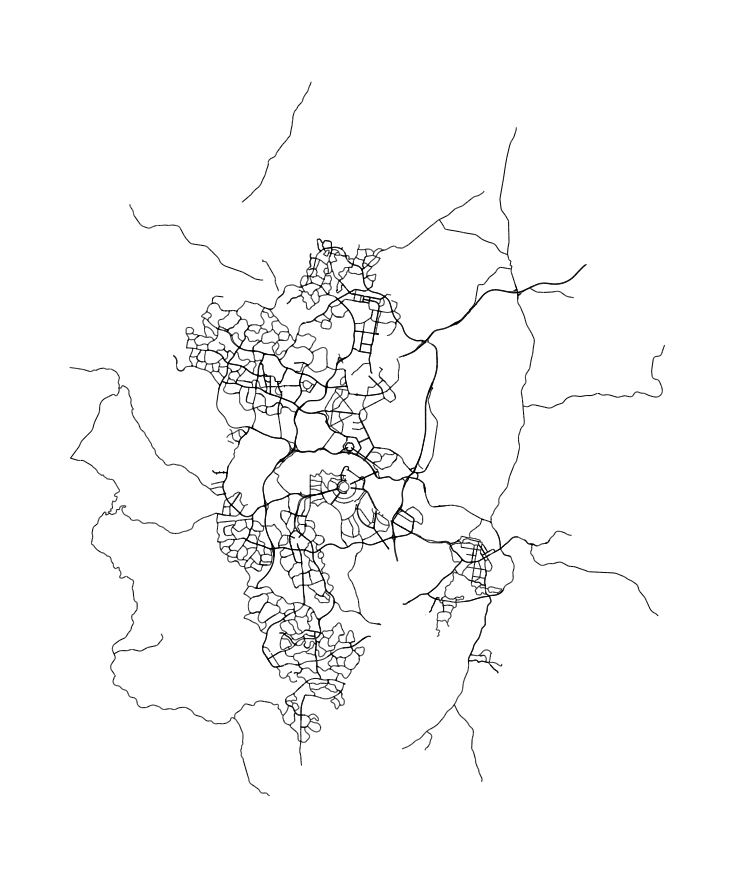

In [25]:
plt.figure(figsize=(10, 12))
nx.draw(G, pos=pos, node_size=0)

In [17]:
from networkx.readwrite import json_graph
import json

In [18]:
d = json_graph.node_link_data(G)

In [19]:
json_nodes = {n['id'].id: [n['id'].lon, n['id'].lat] for n in d['nodes']}

In [20]:
json_links = [{'name': l['name'], 'source': l['source'].id, 'target': l['target'].id} for l in d['links']]

In [21]:
with open('../data/cbr.json', 'w') as f:
    json.dump({'nodes': json_nodes, 'links': json_links}, f)